# Neuronové sítě

Dnes se podíváme na další přírodou inspirované techniky strojového učení -- neuronové sítě. Neuronová síť je výpočetní model určený pro zpracování dat inspirovaný nervovou soustavou. Skládá se z jednotlivých neuronů, které vypadají a fungují na podobné bázi jako neurony v mozku a které jsou navzájem propojené a transformují a dále si předávají signál, který jimi prochází.

Mezi nejjednodušší modely patří perceptron a vícevrstevný perceptron. Na cvičení si je zkusíme sami naiplementovat.

## Perceptron

Perceptron je vlastně jeden neuron. Každý neuron má libovolný počet vstupů, ale pouze jeden výstup. Každý vstup má navíc váhu, která určuje, jak moc je důležitý a jak moc ovlivňuje výslednou hodnotu. Neuron v sobě také obsahuje aktivační funkci, pomocí které vstupní signál transformuje do určitého intervalu a práh, podle kterého se rozhoduje, jestli bude nauron aktivní nebo ne. Užití perceptronu je velmi omezené, protože ho lze použít pouze na množiny, které jsou lineárně separovatelné.

In [1]:
import numpy as np
from sklearn import datasets
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import collections
import tensorflow as tf

2022-03-31 07:10:29.028497: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-31 07:10:29.028532: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Zkusíme si tedy naimplementovat jednoduchý perceptronový algoritmus učení.  K tomu budeme potřebovat třídu ```Perceptron```, kde si definujeme, jak jednoduchý perceptron vypadá. Při inicializaci se nastaví maximální počet iterací a learning rate, který určuje rychlost učení algoritmu, a přípraví se prázdná matice vah rozšířená o jeden sloupeček samých 1, který bude simulovat přičtení prahu.

Perceptron má na vstupu vektor příznaků a vrací jeden výstup jakožto hodnotu přenosové funkce pro daný vstup. Funkce ```predict``` nám tedy pro daný vstup bude predikovat jeho výstup tak, že se spočítá hodnota aktivační funkce ve vstupním bodě a pokud bude větší než 0, bude aktivace 1, jinak bude aktivace 0 (někdy se také může hodit vracet -1 namísto 0). 

Důležité je ještě správně nastavit váhy tak, aby nám neuron dával správné výstupy pro dané vstupy. K tomu budeme potřebovat váhy natrénovat podle vstupních dat a výstupních labelů. K tomu budeme potřebovat ještě funkci ```fit```, kde pro daný vstup spočteme jeho predikovaný výstup a pokud je špatný, tak upravíme váhy tak, aby příště predikoval výstup správně.  

In [2]:
class Perceptron:
    def __init__(self, max_iterations, number_of_inputs, learning_rate=0.1):
        self.max_iterations = max_iterations
        self.learning_rate = learning_rate
        self.weights = np.random.normal(size=number_of_inputs+1)
        
    def predict(self, inputs):
        # spocitame vystup funkce pro dany vstup, vahy a prah
        activation = np.dot(inputs, self.weights[1:]) + self.weights[0]
        # spocitame aktivaci z funkce sgn do {-1,1} a to prevedeme na {0,1}
        return (np.sign(activation)+1)/2
    
    
    def fit(self, inputs, labels):
        for i in range(self.max_iterations):
            for x, y in zip(inputs, labels):
                prediction = self.predict(x)               
                # aktualizujem vahy a prahy
                self.weights[1:] += self.learning_rate * (y - prediction) * x
                self.weights[0] += self.learning_rate * (y - prediction)

Abychom náš perceptron otestovali, vygenerujem si náhodná data pomocí knihovny *scikit-learn*, která nám umí vrátit 2 lineárně separabilí třídy bodů.

In [17]:
inputs, labels = datasets.make_blobs(centers=2, n_samples=200)
perc = Perceptron(100,2)
perc.fit(inputs, labels)

[ 1.14494696  0.54452857 -0.09202463]


Vytvořená data si zobrazíme a vidíme dvě krásně lineárně separovatelné množiny.

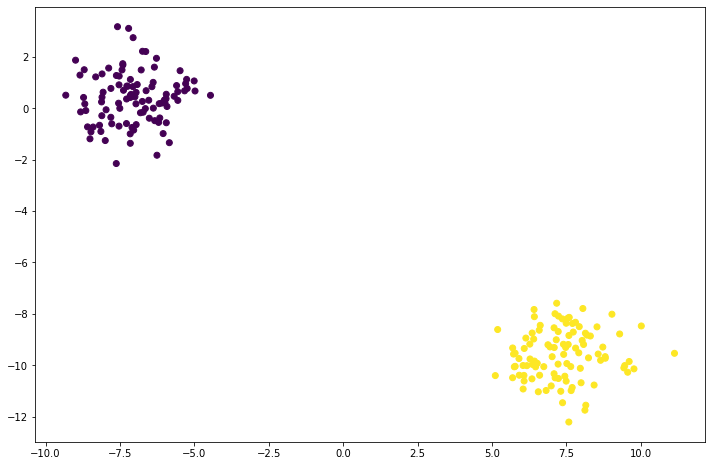

In [15]:
plt.figure(figsize=(12,8))
plt.scatter(inputs[:,0], inputs[:,1], c=labels)
plt.show()

Zkusíme si tedy pustit perceptronový algoritmus učení a natrénovat váhy tak, aby nám uměl rozdělit data na dvě disjunktní množiny.

In [5]:
perc = Perceptron(100,2)
perc.fit(inputs, labels)

Ještě by bylo dobré umět si vizualizovat i výsledky, a proto si napíšeme následující funkci, která bude umět vykreslit data i oddělující nadrovinu.

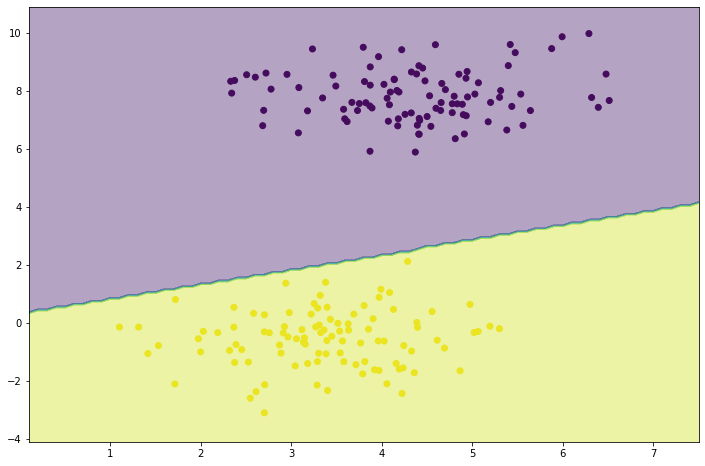

In [6]:
def draw_boundary(model, inputs, labels):
    
    x_min = inputs[:, 0].min() - 1
    x_max = inputs[:, 0].max() + 1
    y_min = inputs[:, 1].min() - 1 
    y_max = inputs[:, 1].max() + 1

    # vytvori obdelnikovou mrizku s vyse spocitanymi rozmery
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    # vykresleni rozhodovaci hranice -- kazdemu bodu se podle tho priradi barva
    predicted = model.predict(np.c_[xx.ravel(), yy.ravel()])
    predicted = predicted.reshape(xx.shape)
    
    plt.figure(figsize=(12,8))
    plt.scatter(inputs[:,0], inputs[:,1], c=labels)
    plt.contourf(xx, yy, predicted, alpha=0.4)
    plt.show()
    
draw_boundary(perc, inputs, labels)

## Vícevrstvý perceptron

Jak už bylo zmíněno výše, tak perceptronový algorimus se dá použít jen v případě lineárně separovatelných dat. Často ale máme lineárně neseparovatelná data, která bychom také chtěli umět rozdělit na podmožniny. K tomu nám ale postačí zkombinovat více jednoduchých neuronů dohromady. Tím nám vznikne neuronová síť neboli vícevrstevný perceptron, kde přidáváním perceptronů do více vrstev rozšiřujeme separabilní schopnosti celého modelu. První vrstva se nazývá vstupní a poslední vrstva výstupní. Mezi nimi se může nacházet libovolné množství skrytých vrstev. 

Neuronové sítě patří do skupiny učení s učitelem, tedy na vstupu vyžadují data ve tvaru vstupní vektor příznaků a odpovídající výstupní hodnota. Průchod sítí pak vypadá tak, že se pro každý vstup spočítá výstup. Pak se spočítá chyba jakožto druhá mocnina rozdílu predikovaného výstupu a skutečného výstupu. Ta se potom zpětně propaguje až k vstupní vrstvě a updatují se váhy tak, aby se v příštím průchodu pro dané vstupy predikovaly správné výstupy. Tomuto zpětnému průchodu se říká backpropagace a slouží právě k natrénování vah neuronové sítě, které se začátku nastaví náhodně a pak se upravují, aby síť predikovala data správně.

Nyní už pojďme na samotnou implementaci. Jednoduchý perceptron už umíme, tak si nyní s jeho pomocí zkusíme napsat vícevrstevný perceptron, neboli celou neuronovou síť. V inicializační části nastavíme velikosti vrstev a poté matice vah mezi jednotlivými vrstvami jakožto náhodné hodnoty. Dále bude potřeba funkce predikce, která pro daný vstup spočítá výstup sítě a následně updatuje váhy pomocí backpropagace. Nakonec bude třeba už jen umět predikovat výstupní hodnotu sítě pro daný vstup.

In [7]:
class MultiLayerPerceptron:
    def __init__(self, layer_sizes,alpha=0.1):
        self.layer_sizes = layer_sizes
        self.layers = []
        self.alpha = alpha
        
        #for (p, n) in zip(self.layer_sizes, self.layer_sizes[1:]):
        #    self.layers.append(np.random.normal(size=(p+1, n)))
            
        for i in range(0,len(self.layer_sizes)-1):
            self.layers.append(np.random.normal(size=(self.layer_sizes[i]+1,self.layer_sizes[i+1])))
            
    def predict(self, X):
        activations = np.array(X)
        try:
            for layer in self.layers:
                activations = 1/(1+np.exp(np.dot(activations, layer[1:])+layer[0]))
                #activations_1 = self._add_ones(activations) # pridame 1 misto prahu
                #activations = 1/(1+np.exp(np.dot(activations_1, layer)))
        except Exception as e:
            print("Activations:", activations)
            raise e

        return activations
    
    def fit(self, inputs, outputs):
        pass
        # je potreba spocitat vystup site
        # pak je potreba update vah pomoci backpropagace
        # zkuste si dopsat sami :P
        
    # pridame sloupecek jednicek k neuronum misto prahu     
    def _add_ones(self, x):
        ones = np.ones(shape=(x.shape[0],1))
        x = np.append(ones,x, axis=1)        
        return x

Nyní si náhodně vygenerujeme data a ověříme, že náš vícevrstevný perceptron opravdu něco dělá.

In [8]:
mlp = MultiLayerPerceptron([3,5,2])
mlp.predict(np.array([[1,2,3], [1,2,7]]))

array([[0.12558971, 0.91819702],
       [0.08487382, 0.83177675]])

## Wine-quality dataset

Zkusíme si neuronovou síť pusiti na něčem zajímavějším než na náhodných datech. Podíváme se na *winequality-white.csv* dataset, který pochází z UCI machine learning repository. Cílem u tohoto datasetu je predikovat kvalitu vína na základě 12 změřených fyzikálních a chemických vlastností. Kvalita se hodnotí na stupnici 0-10. Schválně si dataset načtěme a podívejme se, jak vypadá. 

In [9]:
data = pd.read_csv('winequality-white.csv', delimiter=';')
print(data.head(5))
data.describe()

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


Spočítejme si pro zajímavost rozložení výsledných hodnot kvality vín v datasetu.

In [10]:
counter=collections.Counter(data['quality'])
print(counter)

Counter({6: 2198, 5: 1457, 7: 880, 8: 175, 4: 163, 3: 20, 9: 5})


Z výsledků vidíme, že stupnice kvality je sice na škále 0-10, ale většina výstupů je mezi 5-7 a některé se nám tu ani nevyskytují. Proto si zjednoduššíme práci a dataset si upravíme tak, aby predikoval jen 3 výstupní kategorie s hodnotami 5, 6, 7 tak, že 3 a 4 sloučíme se 5 a zároveň 9 a 8 sloučíme se 7.

In [11]:
data['quality'].replace({3: 5, 4: 5, 8: 7, 9: 7}, inplace=True)
counter=collections.Counter(data['quality'])
print(counter)

Counter({6: 2198, 5: 1640, 7: 1060})


 Na tomto upraveném datasetu si nyní zkusíme pustit vícevrstevný perceptron. 

In [12]:
k = 10 
mlp = MultiLayerPerceptron([len(data.columns),k,data.quality.nunique()])
mlp.predict(data)

array([[0.16355619, 0.5451635 , 0.259557  ],
       [0.16355619, 0.54516355, 0.259557  ],
       [0.16355619, 0.5451635 , 0.259557  ],
       ...,
       [0.16355619, 0.5451635 , 0.259557  ],
       [0.16355619, 0.5451635 , 0.259557  ],
       [0.16355619, 0.5451635 , 0.259557  ]])

## Úkol na cvičení

Vidíme, že výsledky jsou nám k ničemu, protože jednotlivé neurony predikují náhodné hodnoty. Matice vah se totiž nastavuje v initu náhodně a už neprobíhá žádné updatování vah tak, aby síť predkovala něco smyslupnějšího. Proto teď s velkou slávou přichází úkol na cvíčení. Zkuste si doprogramovat funkci ```fit``` a natrénovat váhy pomocí algoritmu backpropagace, aby síť predikovala pro náš vínový dataset nějaké smysluplnější hodnoty. 

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import pylab as pl
import tensorflow as tf
from sklearn import preprocessing
from sklearn.utils import shuffle

def fit():
    pass
    

## Knihovny tensorflow, keras, scikit-learn

Nejprve se seznámíme s pár základními knihovnami, které budeme používat pro snažší vytváření neuronových sítí a práci s nimi. Knihovna *tensorflow* je symbolická matematická knihovna, která slouží pro dataflow, tedy obsahuje grafové moduly a operace, nad kterými se následně dají implementovat různé algoritmy strojového učení. Nad ní běží knihovna *keras*, která je navržena pro snadné experimentování s hlubokýcmi neuronovými sítěmi. Knihovna *scikit-learn* zase obsahuje všechny možné běžné algoritmy strojového učení.

Všechny tyto knihovny byly navrženy, aby uživateli zjednodušili práci se zpracováním dat a následné vytváření predikčních a jiných modelů, ať už pomocí neurovnových sítí nebo jiných algoritmů strojového učení.


Zkusíme si tedy s pomocí těchto knihoven naimplementovat tu samou jednoduchou neuronovou sít, jako jsme si ručně psali výše. Budeme potřebovat si vyrobit data, potom definovat síť a nakonec ji natrénovat na trénovacích datech a nechat ji predikovat a změřit chybu na testovacích datech.

Nejprve si vytvoříme náhodná dvojrozměrná data klasifikovatelná do $n$ tříd, abychom si je mohli i hezky vizualizovat v grafu. K tomu bude potřeba si upravit funkci pro vizualizaci, protože vícetřídová klasifikace nám vrací výstup jakožte pole, kde pro tu jednu vybranou třídu (ideálně) bude na jejím indexu 1 a všude jinde budou 0. Tomuto výstupu se tak říká one-hot-encoding.

In [19]:
def draw_boundary(model, inputs, labels):
    x_min = inputs[:, 0].min() - 1
    x_max = inputs[:, 0].max() + 1
    y_min = inputs[:, 1].min() - 1 
    y_max = inputs[:, 1].max() + 1

    # vytvori obdelnikovou mrizku s vyse spocitanymi rozmery
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    # vykresleni rozhodovaci hranice -- kazdemu bodu se podle tho priradi barva
    predicted = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # pridana radka pro vyber klasifikovane tridy
    predicted = np.argmax(predicted, axis=1)
    
    predicted = predicted.reshape(xx.shape)
    
    plt.figure(figsize=(12,8))
    plt.scatter(inputs[:,0], inputs[:,1], c=labels)
    plt.contourf(xx, yy, predicted, alpha=0.4)
    plt.show()
    model.predict(x_test[:10])

Když mám upravenou funkci pro vizualizaci, tak si vygeneruji náhodná data a podívám se, jak byl model úspěšný. Tedy si rozdělím data na trénovací a testovací a podívám se, jak dobře se model natrénoval na trénovacích datech a jak dobře umí predikovat testovací data.

2022-03-31 07:27:32.011091: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 07:27:32.012805: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-31 07:27:32.013018: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-31 07:27:32.013391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-31 07:27:32.013598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

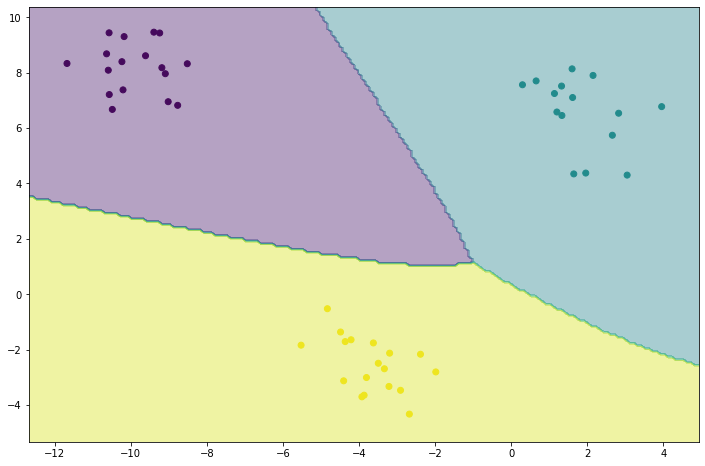

In [20]:
# priprava dat a rozdeleni na trenovaci a testovaci mnoziny
n = 3
x, y = datasets.make_blobs(n_samples=300, centers=n)

x_train, x_test = x[:250], x[250:]
y_train, y_test = y[:250], y[250:]

# definujeme architekturu site
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(5, activation=tf.nn.sigmoid))
model.add(tf.keras.layers.Dense(n, activation=tf.nn.softmax))

# nastavime optimalizaci
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# trenovani site na trenovacich datech
model.fit(x_train, y_train, epochs=200, verbose=0)

# predpovedi na trenovacich datech
draw_boundary(model, x_test, y_test)

Ještě si zkusíme pustit neuronovou síť z tensorflow na nějakém reálném datasetu. Nejjednodušší volbou je dataset o víně, který jsme si už popsali výše. Aby však síť mohla správně klasifikovat labely, je potřeba je posunout z množiny {5, 6, 7} do množiny {0, 1, 2}. Následně ještě provedeme normalizaci ostatních hodnot tak, že všechny budou sloupečky budou mít hodnoty v intervalu [0, 1]. Normalizace se dělá proto, aby se nestalo, že některý sloupeček s hodně vysokými hodnotami bude mít příliš velký vliv na výsledný label, a může potom data zkreslovat. 

In [21]:
# nahodne zamichani dat
data = shuffle(data)

# posun vystupnich labelu
data['quality'].replace({5: 0, 6: 1, 7: 2}, inplace=True)
labels = data['quality'].values

# normalizace dat
values = data[data.columns.difference(['quality'])].values
min_max_scaler = preprocessing.MinMaxScaler()
data_scaled = min_max_scaler.fit_transform(values)

# rozdelime na trenovaci a testovaci mnozinu
x, y = data_scaled, labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# definujeme architekture site
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(5, activation=tf.nn.sigmoid))
model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))

# nastavime optimalizaci
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# natrenujeme sit na trenovacich datech
model.fit(x_train, y_train, epochs=200, verbose=0)

Zkusíme si predikovat výstup na testovacích datech a spočítat chybu. 

In [22]:
# predikce na test datech
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=-1)
model_mse = mean_squared_error(predicted_classes,y_test)
print(model_mse)

0.5836734693877551


Na závěr se podíváme pomocí matice konfuze, která má jakožto sloupce predikované labely a jakožto řádky skutečné labely a která nám říká, která třída byla kolikrát dobře nebo zle predikovaná.

[[214 203   2]
 [141 384  18]
 [ 34 209  20]]


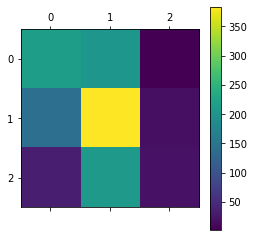

[[419   0   0]
 [  0 543   0]
 [  0   0 263]]


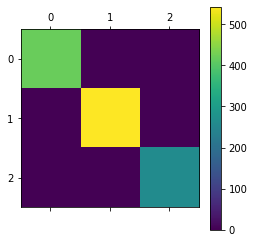

In [23]:
# vykresleni, jak bylo co klasifikovano
confusion_matrix = metrics.confusion_matrix(y_test, predicted_classes)
print(confusion_matrix)

pl.matshow(confusion_matrix)
pl.colorbar()
pl.show()

confusion_matrix = metrics.confusion_matrix(y_test, y_test)
print(confusion_matrix)

pl.matshow(confusion_matrix)
pl.colorbar()
pl.show()